### **Pip Install**

In [ ]:
pip install scikit-optimize

In [ ]:
pip install imagededup

In [ ]:
pip install scikeras

In [ ]:
pip install keras-tuner

### **Import Libraries**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from imagededup.methods import PHash
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import shutil
import keras
import keras_tuner as kt
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from scikeras.wrappers import KerasClassifier
from skopt import BayesSearchCV

### **Import Drive and Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/image_data.csv')
dataset

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
...,...,...,...,...
7904,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7905,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7906,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7907,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X


In [ ]:
def extract_info_from_path(row):
    if pd.isnull(row['Benign or Malignant']):
        row['Benign or Malignant'] = 'Benign' if 'benign' in row['path_to_image'].lower() else 'Malignant'

    if pd.isnull(row['Cancer Type']):
        if 'mucinous_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Mucinous Carcinoma'
        elif 'ductal_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Ductal Carcinoma'
        elif 'lobular_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Lobular Carcinoma'
        elif 'papillary_carcinoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Papillary Carcinoma'
        elif 'adenosis' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Adenosis'
        elif 'tubular_adenoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Tubular Adenoma'
        elif 'fibroadenoma' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Fibroadenoma'
        elif 'phyllodes_tumor' in row['path_to_image'].lower():
            row['Cancer Type'] = 'Phyllodes Tumor'

    if pd.isnull(row['Magnification']):
        if '100x' in row['path_to_image'].lower():
            row['Magnification'] = '100X'
        elif '200x' in row['path_to_image'].lower():
            row['Magnification'] = '200X'
        elif '400x' in row['path_to_image'].lower():
            row['Magnification'] = '400X'
        elif '40x' in row['path_to_image'].lower():
            row['Magnification'] = '40X'

    return row

dataset = dataset.apply(extract_info_from_path, axis=1)

print(dataset.isnull().sum())

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64


In [ ]:
remove_paths = [
    "SOB_B_F-14-23060AB-100-013.png",
    "SOB_B_F-14-23060AB-40-009.png",
    "SOB_B_TA-14-15275-400-009.png",
    "SOB_B_TA-14-3411F-100-011.png",
    "SOB_B_F-14-23222AB-400-010.png",
    "SOB_M_LC-14-12204-40-035.png",
    "SOB_M_LC-14-12204-40-034.png",
    "SOB_M_DC-14-9461-100-004.png",
    "SOB_M_DC-14-9461-100-040.png",
    "SOB_M_LC-14-16196-40-002.png",
    "SOB_M_DC-14-20629-400-019.png",
    "SOB_M_DC-14-13993-100-042.png",
    "SOB_M_DC-14-15792-200-005.png",
    "SOB_M_PC-14-15704-100-026.png"
]

mask = dataset['path_to_image'].apply(lambda x: any(remove_str in x for remove_str in remove_paths))
df_filtered = dataset[~mask]

In [ ]:
df_filtered

,path_to_image,Benign or Malignant,Cancer Type,Magnification
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,Benign,Adenosis,100X
...,...,...,...,...
7904,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7905,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7906,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X
7907,BreaKHis_v1/histology_slides/breast/malignant/...,Malignant,Lobular Carcinoma,200X


In [ ]:
df_filtered['image_name'] = df_filtered['path_to_image'].apply(lambda x: x.split('/')[-1])

<ipython-input-11-2efce3fd7d9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['image_name'] = df_filtered['path_to_image'].apply(lambda x: x.split('/')[-1])


In [ ]:
cancer_type_one_hot = pd.get_dummies(df_filtered['Cancer Type'])
df_filtered = pd.concat([df_filtered, cancer_type_one_hot.astype(int)], axis=1)

### **Create Paths, Folders and Copy Files**

In [ ]:
# Path to the directory where the original dataset was uncompressed
original_dataset_dir = '/content/drive/MyDrive/benigno_maligno'

In [ ]:
# Directory where you'll store your smaller dataset
base_dir = '/content/drive/MyDrive/multi_class_data'

In [ ]:
# Step 1: Split the DataFrame into train, validation, and test sets (80-10-10)
train_df, temp_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
# Create base directories for train, validation, and test
for subset in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(base_dir, subset), exist_ok=True)

# Create subdirectories for each cancer type in train, validation, and test
cancer_types = df_filtered['Cancer Type'].unique()  # Get unique cancer types
for subset in ['train', 'validation', 'test']:
    for tumor in cancer_types:
        os.makedirs(os.path.join(base_dir, subset, tumor), exist_ok=True)

In [ ]:
# Step 5: Move the images into the appropriate folders
def move_images(df, subset):
    for _, row in df.iterrows():
        # Get the full image path
        src_path = os.path.join(original_dataset_dir, row['image_name'])

        # Define destination path
        dst_dir = os.path.join(base_dir, subset, row['Cancer Type'])
        dst_path = os.path.join(dst_dir, row['image_name'])

        # Move the image to the appropriate folder
        shutil.copy(src_path, dst_path)  # You can use shutil.move if you want to move instead of copy

# Move training images
move_images(train_df, 'train')

# Move validation images
move_images(val_df, 'validation')

# Move test images
move_images(test_df, 'test')


In [ ]:
subsets = ['train', 'validation', 'test']
cancer_types = df_filtered['Cancer Type'].unique()  # List of unique cancer types

# Print the number of images in each folder for each cancer type
for subset in subsets:
    print(f"Subset: {subset.capitalize()}")
    for tumor in cancer_types:
        # Get the folder path for the current subset and cancer type
        folder_path = os.path.join(base_dir, subset, tumor)

        # Count the number of images (files) in the folder
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        print(f"  {tumor}: {num_images} images")
    print()  # Blank line for better readability

Subset: Train
  Adenosis: 348 images
  Tubular Adenoma: 454 images
  Fibroadenoma: 795 images
  Phyllodes Tumor: 363 images
  Mucinous Carcinoma: 630 images
  Papillary Carcinoma: 454 images
  Ductal Carcinoma: 2782 images
  Lobular Carcinoma: 490 images

Subset: Validation
  Adenosis: 53 images
  Tubular Adenoma: 58 images
  Fibroadenoma: 99 images
  Phyllodes Tumor: 45 images
  Mucinous Carcinoma: 77 images
  Papillary Carcinoma: 51 images
  Ductal Carcinoma: 334 images
  Lobular Carcinoma: 72 images

Subset: Test
  Adenosis: 43 images
  Tubular Adenoma: 55 images
  Fibroadenoma: 117 images
  Phyllodes Tumor: 45 images
  Mucinous Carcinoma: 85 images
  Papillary Carcinoma: 54 images
  Ductal Carcinoma: 330 images
  Lobular Carcinoma: 61 images



### **Load Model**

In [ ]:
base_model = load_model('/content/drive/MyDrive/benign_malignant_small_2nd.h5')
extended_model = clone_model(base_model)
extended_model.set_weights(base_model.get_weights())

In [ ]:
extended_model.pop()

# Freeze the layers in base model
for layer in extended_model.layers[:-1]:
    layer.trainable = False

In [ ]:
for layer in extended_model.layers:
    print(layer.name)

conv2d_2
batch_normalization
max_pooling2d_2
conv2d_3
batch_normalization_1
max_pooling2d_3
conv2d_4
batch_normalization_2
max_pooling2d_4
flatten_1
dense_2


In [ ]:
extended_model.add(Dense(8, activation='softmax'))

In [ ]:
for layer in extended_model.layers:
    print(layer.name)

conv2d_2
batch_normalization
max_pooling2d_2
conv2d_3
batch_normalization_1
max_pooling2d_3
conv2d_4
batch_normalization_2
max_pooling2d_4
flatten_1
dense_2
dense_3


In [ ]:
extended_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,038,666 (72.63 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 19,034,560 (72.61 MB)

 Optimizer params: 2 (12.00 B)

### **Extend Model**

In [ ]:
extended_model.compile(optimizer='rmsprop',
                       loss='categorical_crossentropy',
                       metrics=['Recall', 'Precision', 'AUC', 'Accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/multi_class_data/train'
validation_dir = '/content/drive/MyDrive/multi_class_data/validation'

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=48,
        class_mode='categorical',
        seed=42,
        shuffle=True)

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        seed=42,
        shuffle=False)

Found 6316 images belonging to 8 classes.
Found 789 images belonging to 8 classes.


In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping (monitor='val_Recall', mode='max', patience=3, restore_best_weights=True)]

history = extended_model.fit(
      train_generator,
      epochs=20,
      #steps_per_epoch=train_generator.n//32,
      callbacks = callbacks_list,
      validation_data=validation_generator,
      #validation_steps = validation_generator.n//16
      )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 111s 782ms/step - AUC: 0.7688 - Accuracy: 0.4211 - Precision: 0.5432 - Recall: 0.2816 - loss: 2.8974 - val_AUC: 0.8593 - val_Accuracy: 0.5057 - val_Precision: 0.7335 - val_Recall: 0.2966 - val_loss: 1.3735
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 105s 760ms/step - AUC: 0.8770 - Accuracy: 0.5164 - Precision: 0.7233 - Recall: 0.3684 - loss: 1.3029 - val_AUC: 0.8710 - val_Accuracy: 0.5032 - val_Precision: 0.7241 - val_Recall: 0.2928 - val_loss: 1.3288
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 104s 754ms/step - AUC: 0.9002 - Accuracy: 0.5471 - Precision: 0.7475 - Recall: 0.4018 - loss: 1.1616 - val_AUC: 0.8818 - val_Accuracy: 0.5019 - val_Precision: 0.7048 - val_Recall: 0.3511 - val_loss: 1.2919
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 104s 754ms/step - AUC: 0.9233 - Accuracy: 0.5739 - Precision: 0.7771 - Recall: 0.4513 - loss: 1.0205 - val_AUC: 0.8861 - val_Accuracy: 0.5399 - val_Precision: 0.7097 - val_Recall: 0.4183 - val_loss: 1.3201
Epoch 5/20
132/132 ━━━━━━━━

In [ ]:
extended_model.save('/content/drive/MyDrive/multi_class_21nd.h5')

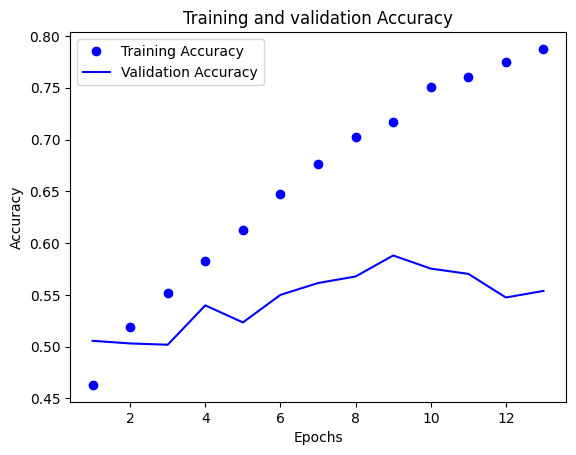

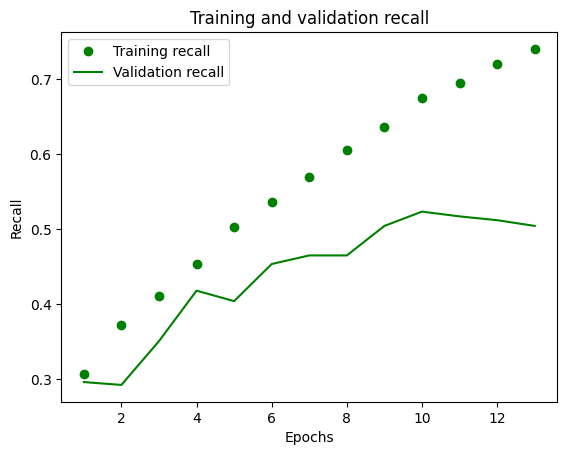

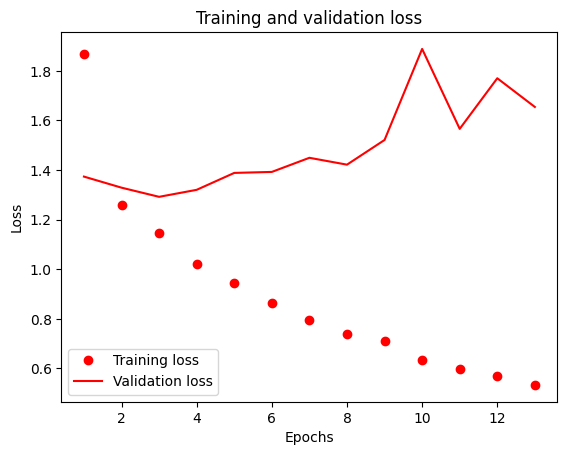

In [ ]:
epochs = range(1, len(accuracy) + 1)

accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.clf()
recall = history.history['Recall']
val_recall = history.history['val_Recall']
plt.plot(epochs, recall, 'go', label='Training recall')
plt.plot(epochs, val_recall, 'g', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Fine-Tuning**

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_classifier(hp):

    classifier = models.Sequential()
    classifier.add(layers.InputLayer(input_shape=(150,150,3)))
    classifier.add(layers.Conv2D(32, (3, 3), activation='relu'))
    classifier.add(layers.MaxPooling2D((2, 2)))
    classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
    classifier.add(layers.MaxPooling2D((2, 2)))
    classifier.add(layers.Flatten())

    classifier.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    classifier.add(layers.Dense(units=8, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['Recall'])

    batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
    epochs = hp.Int('epochs', min_value=10, max_value=30, step=10)

    return classifier

tuner = kt.BayesianOptimization(
    build_classifier,
    objective='val_Recall',
    max_trials=10,
    directory='tuner_results',
    project_name='cnn_finetuning'
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    #steps_per_epoch=len(train_generator),
    epochs=5,
    #validation_steps = len(validation_generator)
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
print("Best Optimizer:", best_hp.get('optimizer'))
print("Best Batch Size:", best_hp.get('batch_size'))
print("Best Number of Epochs:", best_hp.get('epochs'))
print(best_model.summary())

Trial 10 Complete [00h 09m 01s]
val_Recall: 0.39923954010009766

Best val_Recall So Far: 0.39923954010009766
Total elapsed time: 01h 30m 33s
Best Optimizer: rmsprop
Best Batch Size: 48
Best Number of Epochs: 30


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,384 (40.58 MB)

 Trainable params: 10,637,384 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

None


# **Multiclass-Classifier with Undersampling**

In [ ]:
base_model_2 = load_model('/content/drive/MyDrive/benign_malignant_small_2nd.h5')
extended_model_2 = clone_model(base_model_2)
extended_model_2.set_weights(base_model_2.get_weights())

In [ ]:
for layer in extended_model_2.layers:
    print(layer.name)

conv2d_2
batch_normalization
max_pooling2d_2
conv2d_3
batch_normalization_1
max_pooling2d_3
conv2d_4
batch_normalization_2
max_pooling2d_4
flatten_1
dense_2
dense_3


In [ ]:
extended_model_2.pop()
extended_model_2.pop()
extended_model_2.pop()

<Flatten name=flatten_1, built=True>

In [ ]:
for layer in extended_model_2.layers:
    print(layer.name)

conv2d_2
batch_normalization
max_pooling2d_2
conv2d_3
batch_normalization_1
max_pooling2d_3
conv2d_4
batch_normalization_2
max_pooling2d_4


In [ ]:
for layer in extended_model_2.layers[:-3]:
    layer.trainable = False

In [ ]:
extended_model_2.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_5'))
extended_model_2.add(layers.BatchNormalization(name='batch_normalization_3'))
extended_model_2.add(layers.MaxPooling2D((2, 2)))
extended_model_2.add(layers.Flatten())
extended_model_2.add(layers.Dense(512, activation='relu'))
extended_model_2.add(layers.Dropout(0.5))
extended_model_2.add(layers.Dense(8, activation='softmax'))

In [ ]:
for layer in extended_model_2.layers:
    print(layer.name)

conv2d_2
batch_normalization
max_pooling2d_2
conv2d_3
batch_normalization_1
max_pooling2d_3
conv2d_4
batch_normalization_2
max_pooling2d_4
conv2d
conv2d_1
batch_normalization_3
max_pooling2d
flatten
dense_1
dropout
dense_2


In [ ]:
train_datagen_undersampling = ImageDataGenerator(rescale=1./255)
val_datagen_undersampling = ImageDataGenerator(rescale=1./255)

train_dir_und= '/content/drive/MyDrive/multi_class_undersampling/train'
validation_dir_und = '/content/drive/MyDrive/multi_class_undersampling/validation'

train_generator_undersampling = train_datagen.flow_from_directory(
        train_dir_und,
        target_size=(150, 150),
        batch_size=48,
        class_mode='categorical',
        seed=42,
        shuffle=True)

validation_generator_undersampling = val_datagen.flow_from_directory(
        validation_dir_und,
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        seed=42,
        shuffle=False)

Found 4329 images belonging to 8 classes.
Found 789 images belonging to 8 classes.


In [ ]:
extended_model_2.compile(optimizer='rmsprop',
                       loss='categorical_crossentropy',
                       metrics=['Recall', 'Precision', 'AUC', 'Accuracy'])

In [ ]:
callbacks_list_2 = [keras.callbacks.EarlyStopping (monitor='val_Recall', mode='max', patience=5, restore_best_weights=True)]

history_2 = extended_model_2.fit(
      train_generator_undersampling,
      epochs=20,
      #steps_per_epoch=train_generator.n//32,
      callbacks = callbacks_list_2,
      validation_data=validation_generator_undersampling,
      #validation_steps = validation_generator.n//16
      )

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 776ms/step - AUC: 0.7766 - Accuracy: 0.3890 - Precision: 0.4969 - Recall: 0.2440 - loss: 1.9831 - val_AUC: 0.8482 - val_Accuracy: 0.4753 - val_Precision: 0.5270 - val_Recall: 0.4449 - val_loss: 1.8367
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 74s 765ms/step - AUC: 0.8468 - Accuracy: 0.4726 - Precision: 0.5643 - Recall: 0.3259 - loss: 1.6008 - val_AUC: 0.8745 - val_Accuracy: 0.4956 - val_Precision: 0.5833 - val_Recall: 0.3549 - val_loss: 1.3675
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 74s 766ms/step - AUC: 0.8768 - Accuracy: 0.5242 - Precision: 0.6476 - Recall: 0.3955 - loss: 1.3910 - val_AUC: 0.8753 - val_Accuracy: 0.5374 - val_Precision: 0.5682 - val_Recall: 0.5070 - val_loss: 1.6782
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 74s 765ms/step - AUC: 0.8987 - Accuracy: 0.5796 - Precision: 0.6733 - Recall: 0.4552 - loss: 1.2485 - val_AUC: 0.8991 - val_Accuracy: 0.5640 - val_Precision: 0.6178 - val_Recall: 0.5019 - val_loss: 1.3744
Epoch 5/20
91/91 ━━━━━━━━━━━

In [ ]:
extended_model_2.save('/content/drive/MyDrive/multi_class_undersample_21.h5')

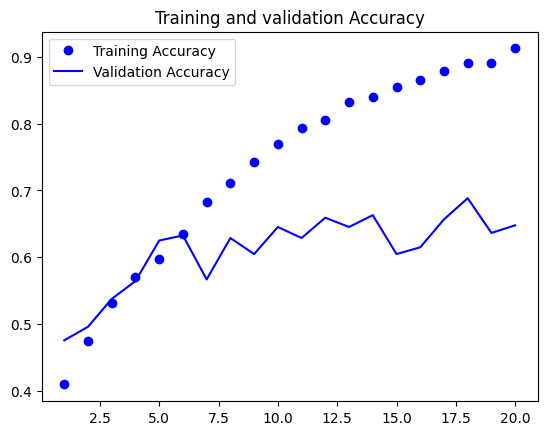

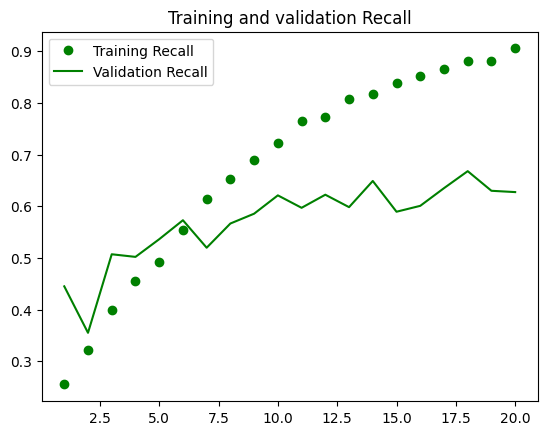

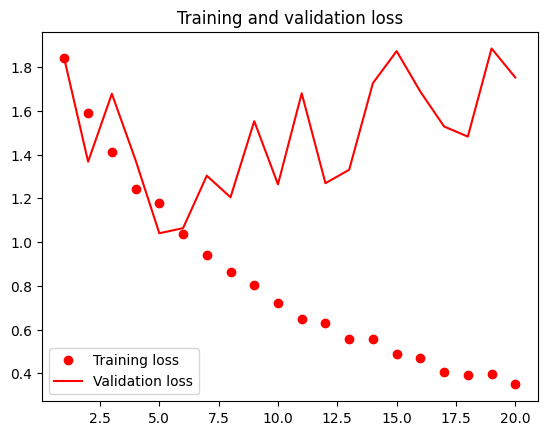

In [ ]:
accuracy = history_2.history['Accuracy']
val_accuracy = history_2.history['val_Accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
recall = history_2.history['Recall']
val_recall = history_2.history['val_Recall']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'go', label='Training Recall')
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test Model 2 (Best Model from stage 1, plus some extra layers for a more robust model and with undersampling)

In [ ]:
test_datagen_2 = ImageDataGenerator(rescale=1./255)

test_dir_2 = '/content/drive/MyDrive/multi_class_data/test'

test_generator_2 = test_datagen_2.flow_from_directory(
    test_dir_2,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    shuffle=False)

Found 790 images belonging to 8 classes.


In [ ]:
test_loss_2, test_accuracy_2, test_recall_2, test_auc_2, test_precision_2= extended_model_2.evaluate(test_generator_2)
print(f"Test Recall: {test_recall_2}")
print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")
print(f"Test AUC: {test_auc_2}")
print(f"Test Precision: {test_precision_2}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - AUC: 0.9160 - Accuracy: 0.6887 - Precision: 0.7110 - Recall: 0.6725 - loss: 1.6160
Test Recall: 0.6910569071769714
Test Loss: 1.6783428192138672
Test Accuracy: 0.6455696225166321
Test AUC: 0.9164415001869202
Test Precision: 0.6696202754974365


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step


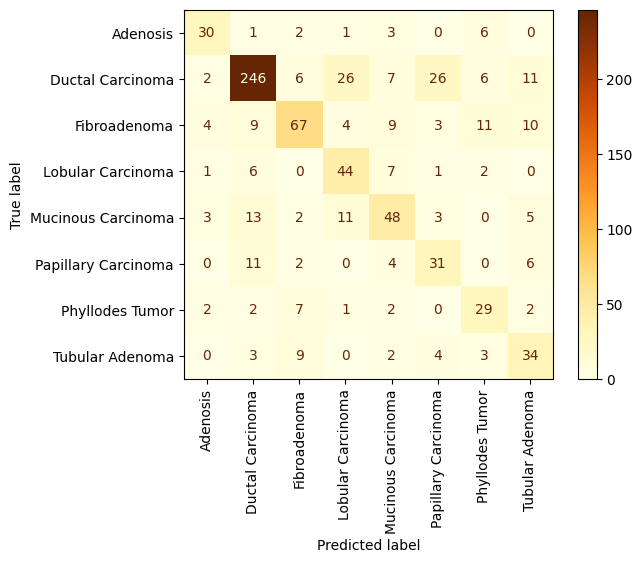

In [ ]:
y_pred_probabilities_2 = extended_model_2.predict(test_generator_2)

y_pred_2 = np.argmax(y_pred_probabilities_2, axis=1)  # Get the class with the highest probability

# Get true class labels from the test generator
y_true_2 = test_generator_2.classes

# Compute confusion matrix
cm_2 = confusion_matrix(y_true_2, y_pred_2)

# Display confusion matrix with yellow color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=test_generator_2.class_indices.keys())
disp.plot(cmap='YlOrBr')  # Use yellow colormap

plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()

# Test Model 1 (Best model from stage 1, as it is with less layers, without undersampling)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = '/content/drive/MyDrive/multi_class_data/test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    seed=42,
    shuffle=False)

Found 790 images belonging to 8 classes.


In [ ]:
test_loss, test_accuracy, test_recall, test_auc, test_precision= extended_model.evaluate(test_generator)
print(f"Test Recall: {test_recall}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - AUC: 0.9206 - Accuracy: 0.6674 - Precision: 0.6991 - Recall: 0.5849 - loss: 1.1534
Test Recall: 0.5996955633163452
Test Loss: 1.829423427581787
Test Accuracy: 0.49873417615890503
Test AUC: 0.866919994354248
Test Precision: 0.550632894039154


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step


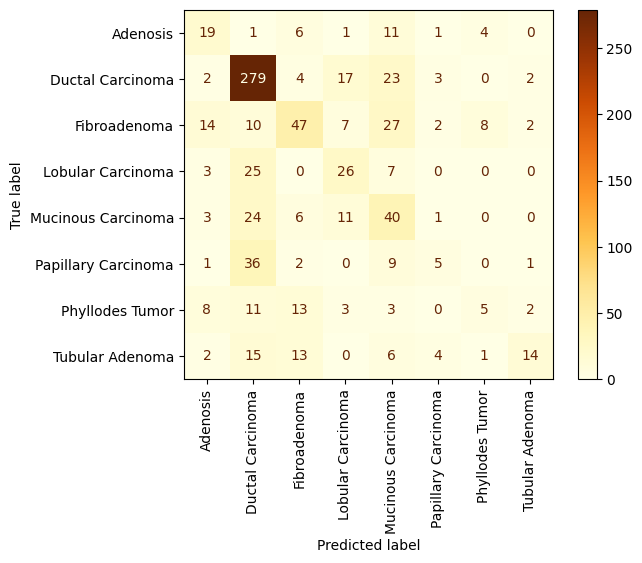

In [ ]:
y_pred_probabilities = extended_model.predict(test_generator)

y_pred = np.argmax(y_pred_probabilities, axis=1)  # Get the class with the highest probability

# Get true class labels from the test generator
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='YlOrBr')

plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.show()

In [ ]:
for layer in extended_model.layers:
    print(layer.name, layer.get_weights())

conv2d_2 [array([[[[ 0.10243239,  0.04279929, -0.04463222,  0.09301367,
          -0.03814603, -0.1057483 ,  0.09309982,  0.0478522 ,
           0.07733221,  0.06775049, -0.08624497,  0.11227648,
          -0.0265351 , -0.05669731, -0.09710915, -0.04820974,
           0.08732265, -0.13976581,  0.09973816, -0.03956135,
          -0.11523394,  0.07133217,  0.03780562,  0.12208898,
          -0.05146946,  0.07253353,  0.14491169,  0.07914344,
          -0.02358864, -0.07397797,  0.03744958, -0.11219481],
         [ 0.02266524,  0.09727544, -0.16161926, -0.05550329,
           0.01228642,  0.03527398,  0.13406958, -0.05954123,
           0.10139599,  0.09018086, -0.12382103,  0.09409575,
           0.00078002,  0.05703955,  0.1010288 , -0.0513257 ,
          -0.06401663,  0.11918229, -0.09163896,  0.04972961,
          -0.05598654, -0.00961971,  0.01902201,  0.1093061 ,
           0.07261524,  0.00277252,  0.1265405 ,  0.00602201,
           0.02494892, -0.1373202 ,  0.02607183, -0.0118576

In [ ]:
for layer in extended_model_2.layers:
    print(layer.name, layer.get_weights())

conv2d_2 [array([[[[ 0.10243239,  0.04279929, -0.04463222,  0.09301367,
          -0.03814603, -0.1057483 ,  0.09309982,  0.0478522 ,
           0.07733221,  0.06775049, -0.08624497,  0.11227648,
          -0.0265351 , -0.05669731, -0.09710915, -0.04820974,
           0.08732265, -0.13976581,  0.09973816, -0.03956135,
          -0.11523394,  0.07133217,  0.03780562,  0.12208898,
          -0.05146946,  0.07253353,  0.14491169,  0.07914344,
          -0.02358864, -0.07397797,  0.03744958, -0.11219481],
         [ 0.02266524,  0.09727544, -0.16161926, -0.05550329,
           0.01228642,  0.03527398,  0.13406958, -0.05954123,
           0.10139599,  0.09018086, -0.12382103,  0.09409575,
           0.00078002,  0.05703955,  0.1010288 , -0.0513257 ,
          -0.06401663,  0.11918229, -0.09163896,  0.04972961,
          -0.05598654, -0.00961971,  0.01902201,  0.1093061 ,
           0.07261524,  0.00277252,  0.1265405 ,  0.00602201,
           0.02494892, -0.1373202 ,  0.02607183, -0.0118576